# Training a regression with outputs shaped by Guassian

Use pytorch to take into account the correlation during the training, and force the output distributions to be shaped by a Gaussian.

## Settings

In [ ]:
n_variables = 8 # Number of data and background varialbes to generate
n_samples = 100000 # Number of samples to generate

center_signal = 2.0 # Where the gaussian for signal should be
center_background = 1.0 # Where the gaussian for background should be

In [2]:
import sys
sys.path += ['../abcdlib']
import data_gen

import seaborn as sns
import pandas as pd
from torch import nn
from torch import optim
import torch
import numpy as np
import matplotlib.pyplot as plt

## Generate the data

In [3]:
sig = data_gen.generate_gaussian(n_variables, center_signal, n_samples)
back = data_gen.generate_gaussian(n_variables, center_background, n_samples)

n_training_samples = int(n_samples/2)

training = data_gen.combine(sig[:n_training_samples], back[:n_training_samples])
testing = data_gen.combine(sig[n_training_samples:], back[n_training_samples:])

## Train with two outputs and a custom loss function

For a regression, we need just a single output column with the 1 or 0 as the target value. Of course, this time we need 2 columns, duplicated.

In [4]:
label = training[training.columns[-1]].values
labels = np.stack((label, label), axis=1)

In [5]:
x_train = torch.Tensor(training[training.columns[:-1]].values)
y_train = torch.Tensor(labels)

The loss function should be a combination of the normal accuracy loss function and also the correlation on background (only), and shape the background to look like a Guassian (also only on the background).

- Use the accuracy on all the training data
- Calculate the correlation only on items marked as being background
- Turn the background variable distirbution into a z-scoare, and then match it to a guassian curve we have pre-generated.

In [6]:
def calc_r(prediction):
    mean = torch.mean(prediction, dim=0)
    std_dev = torch.std(prediction, dim=0)
    parts = (prediction - mean)
    sum = torch.sum(parts[:,0]*parts[:,1])
    return sum / std_dev[0] / std_dev[1] / (prediction.shape[0]-1)

class decorrelate_loss:
    '''Calculate the loss function using MSELoss and decorrelation loss
    '''
    def __init__(self):
        self._mse = nn.MSELoss(reduction='mean')
        self._unit_gaussian, _ = torch.sort(torch.randn((n_training_samples, 2)), dim=0)
        self._loss_record = []
        
    def calc_gausian_shape_difference(self, background):
        # Turn background into z score
        mean = torch.mean(background, dim=0)
        std_dev = torch.std(background, dim=0)
        z_score, _ = torch.sort((background - mean)/std_dev, dim=0)
        
        return self._mse(z_score, self._unit_gaussian)

    def __call__(self, prediction, labels):
        'Calc the loss given both the correlation and mse'
        mse_loss = self._mse(prediction, labels)
        
        background_mask = labels[:,1] == 0
        signal_mask = labels[:,1] == 1
        r = calc_r(prediction[background_mask])
        
        g1 = self.calc_gausian_shape_difference(prediction[background_mask])
        g2 = self.calc_gausian_shape_difference(prediction[signal_mask])
        
        total = mse_loss + torch.square(r)*20 + g1 + g2
        self._loss_record.append((float(mse_loss.item()),
                                  float((torch.square(r)*2.0).item()),
                                  float(g1.item()),
                                  float(g2.item())))
        # print(total)
        return total

Next create a simple classifier - 2 layers, with the same number of nodes as inputs. It looks like doubling the size of the inputs and outputs makes a big difference, but in general getting this to train better hasn't been successful so far. No idea why.

In [7]:
model = nn.Sequential(nn.Linear(n_variables, n_variables*2),
                      nn.ReLU(),
                      nn.Linear(n_variables*2, n_variables*4),
                      nn.ReLU(),
                      nn.Linear(n_variables*4, n_variables*16),
                      nn.ReLU(),
                      nn.Linear(n_variables*16, n_variables*32),
                      nn.ReLU(),
                      nn.Linear(n_variables*32, n_variables*32),
                      nn.ReLU(),
                      nn.Linear(n_variables*32, n_variables*16),
                      nn.ReLU(),
                      nn.Linear(n_variables*16, n_variables*5),
                      nn.ReLU(),
                      nn.Linear(n_variables*5, n_variables*2),
                      nn.ReLU(),
                      nn.Linear(n_variables*2, n_variables),
                      nn.ReLU(),
                      nn.Linear(n_variables, 2))
criterion = decorrelate_loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Now lets do the training

In [ ]:
%%time
epochs = 50000
for e in range(epochs):
    running_loss = 0
    optimizer.zero_grad()
    output = model(x_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    if e % 300 == 0:
        print(f'Training loss ({e}): {running_loss/len(x_train)}')
else:
    print(f'Training loss: {running_loss/len(x_train)}')

Training loss (0): 4.4018049240112304e-05
Training loss (300): 5.710722208023071e-06
Training loss (600): 5.578623414039612e-06
Training loss (900): 5.432118773460388e-06
Training loss (1200): 5.289040803909302e-06
Training loss (1500): 5.144481658935547e-06
Training loss (1800): 5.013611912727356e-06
Training loss (2100): 4.8825660347938536e-06
Training loss (2400): 4.774410128593445e-06
Training loss (2700): 4.685752093791961e-06
Training loss (3000): 4.617855846881867e-06
Training loss (3300): 4.569918513298034e-06
Training loss (3600): 4.549534022808075e-06
Training loss (3900): 4.526600539684295e-06
Training loss (4200): 4.5143780112266545e-06
Training loss (4500): 4.507200121879577e-06
Training loss (4800): 4.504332840442658e-06
Training loss (5100): 4.496100246906281e-06
Training loss (5400): 4.489827752113342e-06
Training loss (5700): 4.485073089599609e-06
Training loss (6000): 4.477247595787049e-06
Training loss (6300): 4.478383362293243e-06
Training loss (6600): 4.48109298944

In [17]:
loss_info_mse = [
    {
        'loss': mse,
        'type': 'mse',
        'epoch': i
    }
    for i, (mse, corr, gaus_b ,gaus_s) in enumerate(criterion._loss_record)
]
loss_info_corr = [
    {
        'loss': corr,
        'type': 'correlation',
        'epoch': i
    }
    for i, (mse, corr, gaus_b ,gaus_s) in enumerate(criterion._loss_record)
]
loss_info_back_gauss = [
    {
        'loss': gaus_b,
        'type': 'back gaussian',
        'epoch': i
    }
    for i, (mse, corr, gaus_b ,gaus_s) in enumerate(criterion._loss_record)
]
loss_info_sig_gauss = [
    {
        'loss': gaus_s,
        'type': 'signal gaussian',
        'epoch': i
    }
    for i, (mse, corr, gaus_b ,gaus_s) in enumerate(criterion._loss_record)
]
loss_trends = pd.DataFrame(loss_info_mse + loss_info_corr + loss_info_back_gauss + loss_info_sig_gauss)

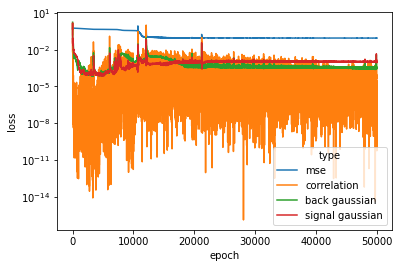

In [18]:
_ = sns.lineplot(x='epoch', y='loss', hue='type', data=loss_trends)
plt.yscale('log')

## Prediction

Get the predicted probabilities out and see where they line up and how well this guy did!

In [19]:
x_test = torch.Tensor(testing[testing.columns[:-1]].values)
y_test = model(x_test)

In [20]:
x_results = testing.copy()
x_results['Prediction_1'] = y_test.detach().numpy()[:,0]
x_results['Prediction_2'] = y_test.detach().numpy()[:,1]

<AxesSubplot:xlabel='Prediction_1', ylabel='Count'>

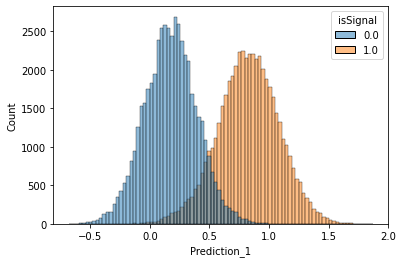

In [21]:
sns.histplot(x_results, x='Prediction_1', hue='isSignal')

<AxesSubplot:xlabel='Prediction_2', ylabel='Count'>

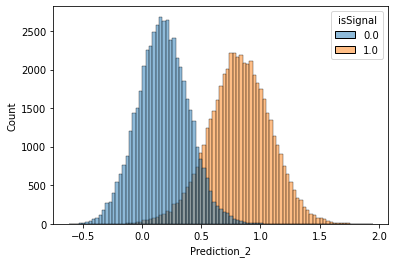

In [22]:
sns.histplot(x_results, x='Prediction_2', hue='isSignal')

Lets look at the correlation between these on background and signal data

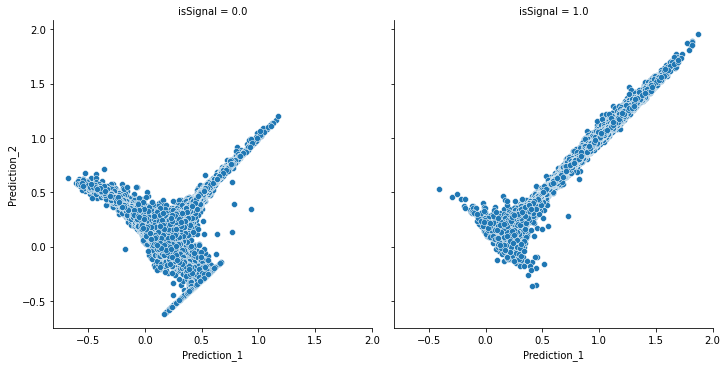

In [23]:
sns.relplot(data=x_results, x='Prediction_1', y='Prediction_2', col='isSignal')

Other than something odd going on down near zero, this looks very correlated for background (and signal). We need the background to be uncorrelated...

## Correlation for the background

Lets see what the final number of the correlation is of the background

In [25]:
label = torch.Tensor(testing[testing.columns[-1]].values)
mask = label == 0.0
calc_r(y_test[mask])

tensor(0.0226, grad_fn=<DivBackward0>)